In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import pytz
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree, export_text
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure you have the necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

np.random.seed(0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Load Dataset

Load the Twitter datasets and explore the datasets. Data is available here: https://ucla.app.box.com/s/24oxnhsoj6kpxhl6gyvuck25i3s4426d

In [4]:
# specify the directory containing your files
directory = '/content/drive/My Drive/twitter'

# list all text files in the directory
file_names = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt')]

# print file names
print(file_names)

['/content/drive/My Drive/twitter/tweets_#gohawks.txt', '/content/drive/My Drive/twitter/tweets_#gopatriots.txt', '/content/drive/My Drive/twitter/tweets_#nfl.txt', '/content/drive/My Drive/twitter/tweets_#patriots.txt', '/content/drive/My Drive/twitter/tweets_#sb49.txt', '/content/drive/My Drive/twitter/tweets_#superbowl.txt']


In [5]:
# function to load and parse tweets from a file
def load_tweets(file_name):
    with open(file_name, 'r') as file:
        tweets = [json.loads(line) for line in file]
    return tweets

In [6]:
# look at the content of a tweet
#tweets = load_tweets(file_names[0])
#print(tweets[0])

In [7]:
# list all keys in the dictionary
#print(tweets[1].keys())

In [8]:
# function to extract hashtag from filename
def get_hashtag_from_filename(file_name):
    base_name = os.path.basename(file_name)
    # Remove the file extension
    file_without_extension = os.path.splitext(base_name)[0]
    # Extract the text after the '#'
    hashtag = file_without_extension.split('#')[-1]
    return hashtag

In [9]:
# function to extract required information from tweets
def extract_tweet_info(tweet, hashtag):
    time_posted = tweet['citation_date']
    # convert to UTC time
    utc_time = datetime.datetime.utcfromtimestamp(time_posted).replace(tzinfo=pytz.utc)
    # convert to PST timezone
    pst_timezone = pytz.timezone('US/Pacific')
    time_posted = utc_time.astimezone(pst_timezone)
    # extract the text
    # print(tweet['tweet']['text']
    text = tweet['tweet']['text']
    # extract the author name
    author_name = tweet['author']['name']
    retweets = tweet['metrics']['citations']['total']
    followers = tweet['author']['followers']


    return {
      'time_posted': time_posted,
      'retweets': retweets,
      'followers': followers,
      'author_name': author_name,
      'hashtag': hashtag,
      'text': text
    }

In [10]:
# load and process tweets from all files
all_tweets_data = []

#for file_name in file_names:
    #hashtag = get_hashtag_from_filename(file_name)
    #tweets = load_tweets(file_name)
    #for tweet in tweets:
        #tweet_info = extract_tweet_info(tweet, hashtag)
        #all_tweets_data.append(tweet_info)

In [11]:
# print the first 5 tweet info
#for tweet_info in all_tweets_data[:10]:
    #print(tweet_info)

In [12]:
# create a dataframe from the tweet data
#df = pd.DataFrame(all_tweets_data)

In [13]:
# create a time posted column in the dataframe
#df['time_posted'] = pd.to_datetime(df['time_posted'], unit='s')

In [14]:
#print(df.head())

In [15]:
#summary = df.describe()
#summary_rounded = summary.round(2)
#print(summary_rounded)

In [16]:
# save the df as a pickle file back to Google Drive
#df.to_pickle('/content/drive/My Drive/twitter/all_tweets.pkl')

In [17]:
# reload the pickle file for analysis
df = pd.read_pickle('/content/drive/My Drive/twitter/all_tweets.pkl')

# Question 9.1

Report the following statistics for each hashtag, i.e. each file:
• Average number of tweets per hour
• Average number of followers of users posting the tweets per tweet (to make it simple,
we average over the number of tweets; if a users posted twice, we count the user
and the user’s followers twice as well)
• Average number of retweets per tweet

In [18]:
# function to calculate statistics on each hashtag
def calculate_statistics(df):
    hashtags = df['hashtag'].unique()
    stats = []

    for hashtag in hashtags:
        hashtag_df = df[df['hashtag'] == hashtag]

        # set 'time_posted' as the index for resampling
        hashtag_df.set_index('time_posted', inplace=True)
        # resample by hour (H) and count the number of tweets per hour
        tweets_per_hour = hashtag_df.resample('H').size().mean()
        avg_followers_per_tweet = hashtag_df['followers'].mean()
        avg_retweets_per_tweet = hashtag_df['retweets'].mean()
        total_tweets = hashtag_df.shape[0]

        stats.append({
            'hashtag': hashtag,
            'avg_tweets_per_hour': tweets_per_hour,
            'avg_followers_per_tweet': avg_followers_per_tweet,
            'avg_retweets_per_tweet': avg_retweets_per_tweet,
            'total_tweets': total_tweets
        })

    return stats

In [19]:
# calculate statistics and print results
statistics = calculate_statistics(df)
for stat in statistics:
    print(f"Hashtag: {stat['hashtag']}")
    print(f"Average number of tweets per hour: {stat['avg_tweets_per_hour']:.2f}")
    print(f"Average number of followers per tweet: {stat['avg_followers_per_tweet']:.2f}")
    print(f"Average number of retweets per tweet: {stat['avg_retweets_per_tweet']:.2f}")
    print(f"Total tweets: {stat['total_tweets']}\n")

Hashtag: gohawks
Average number of tweets per hour: 292.09
Average number of followers per tweet: 2217.92
Average number of retweets per tweet: 2.01
Total tweets: 169122

Hashtag: gopatriots
Average number of tweets per hour: 40.89
Average number of followers per tweet: 1427.25
Average number of retweets per tweet: 1.41
Total tweets: 23511

Hashtag: nfl
Average number of tweets per hour: 396.97
Average number of followers per tweet: 4662.38
Average number of retweets per tweet: 1.53
Total tweets: 233022

Hashtag: patriots
Average number of tweets per hour: 750.63
Average number of followers per tweet: 3280.46
Average number of retweets per tweet: 1.79
Total tweets: 440621

Hashtag: sb49
Average number of tweets per hour: 1275.56
Average number of followers per tweet: 10374.16
Average number of retweets per tweet: 2.53
Total tweets: 743649

Hashtag: superbowl
Average number of tweets per hour: 2067.82
Average number of followers per tweet: 8814.97
Average number of retweets per tweet: 2

# Question 9.2

Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with 1-hour bins). The tweets are stored in separate files for different hashtags and files are named as tweet [#hashtag].txt.


# Filter data by dates to see more granular trends by hashtag

In [20]:
# function to filter, resample, and plot by date and hashtag
def filter_resample_plot(df, start_date_str, end_date_str, hashtags):
    """
    Parameters:
    start_date_str (str): The start date in 'YYYY-MM-DD' format.
    end_date_str (str): The end date in 'YYYY-MM-DD' format.
    hashtags (list): List of hashtags to filter and plot.
    """
    # convert start and end dates to datetime with timezone
    seattle_tz = pytz.timezone('US/Pacific')
    start_date = seattle_tz.localize(datetime.strptime(start_date_str, '%Y-%m-%d'))
    end_date = seattle_tz.localize(datetime.strptime(end_date_str, '%Y-%m-%d'))

    # filter data for the specific date range in PST timezone
    filtered_df = df[(df['time_posted'] >= start_date) & (df['time_posted'] < end_date)]

    plt.figure(figsize=(15, 8))

    # iterate over each hashtag and plot the resampled data
    for hashtag in hashtags:
        hashtag_df = filtered_df[filtered_df['hashtag'] == hashtag]

        # resample data to 1-hour bins
        hashtag_df.set_index('time_posted', inplace=True)
        resampled = hashtag_df.resample('H').size()

        # plot
        plt.bar(resampled.index, resampled, width=0.03, label=f'#{hashtag}', alpha=0.7)

    # Formatting the plot
    plt.xlabel('Time')
    plt.ylabel('Number of Tweets')
    plt.title(f'Number of Tweets per Hour for {", ".join(["#" + h for h in hashtags])} from {start_date_str} to {end_date_str} (PST)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

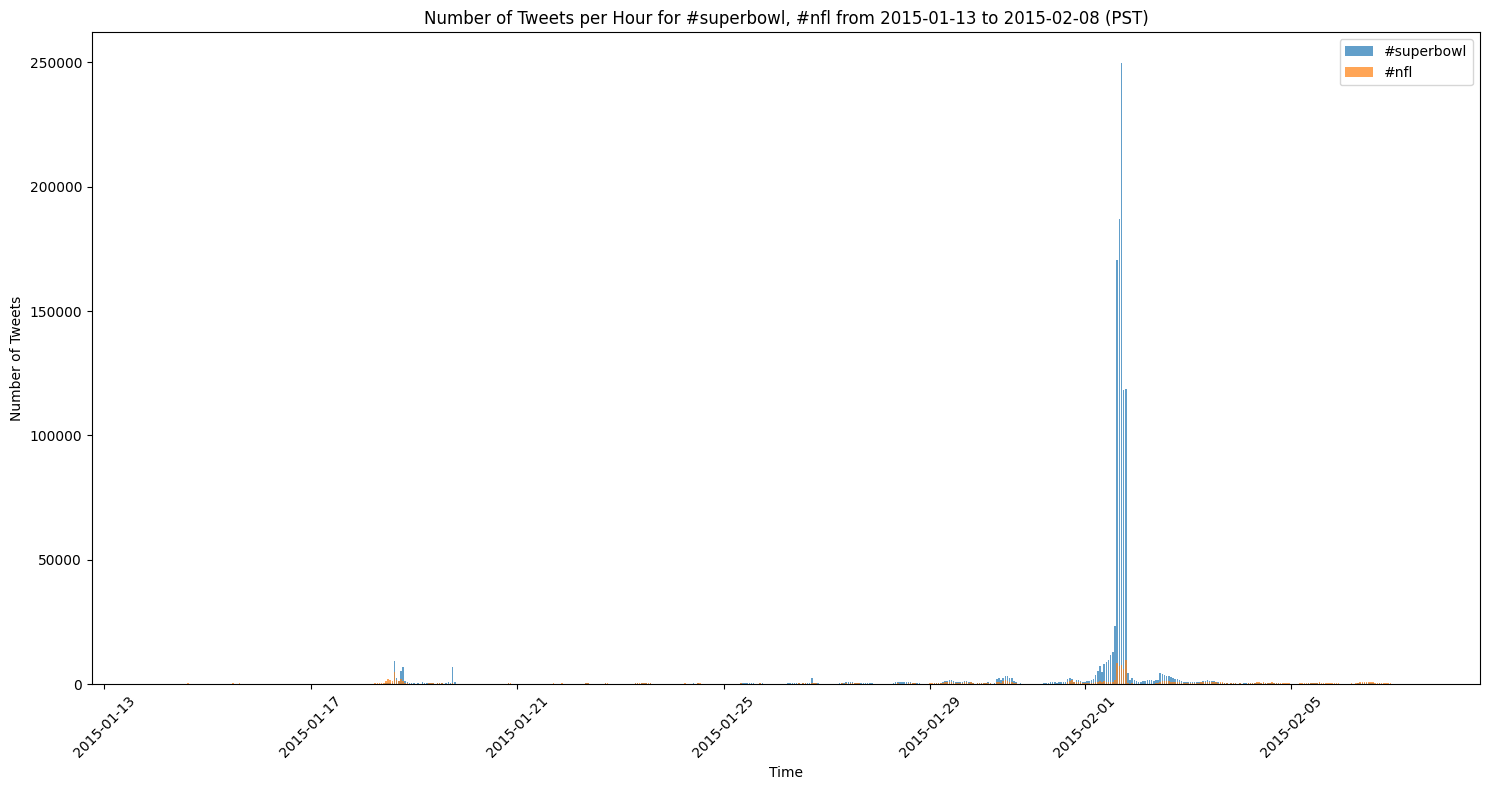

In [21]:
# lets look at the entire time span
filter_resample_plot(df, '2015-01-13', '2015-02-08', ['superbowl', 'nfl'])

We can see that the majority of the tweet activity centers around the championship games on 1/18/15 and the Superbowl on 2/1/15.

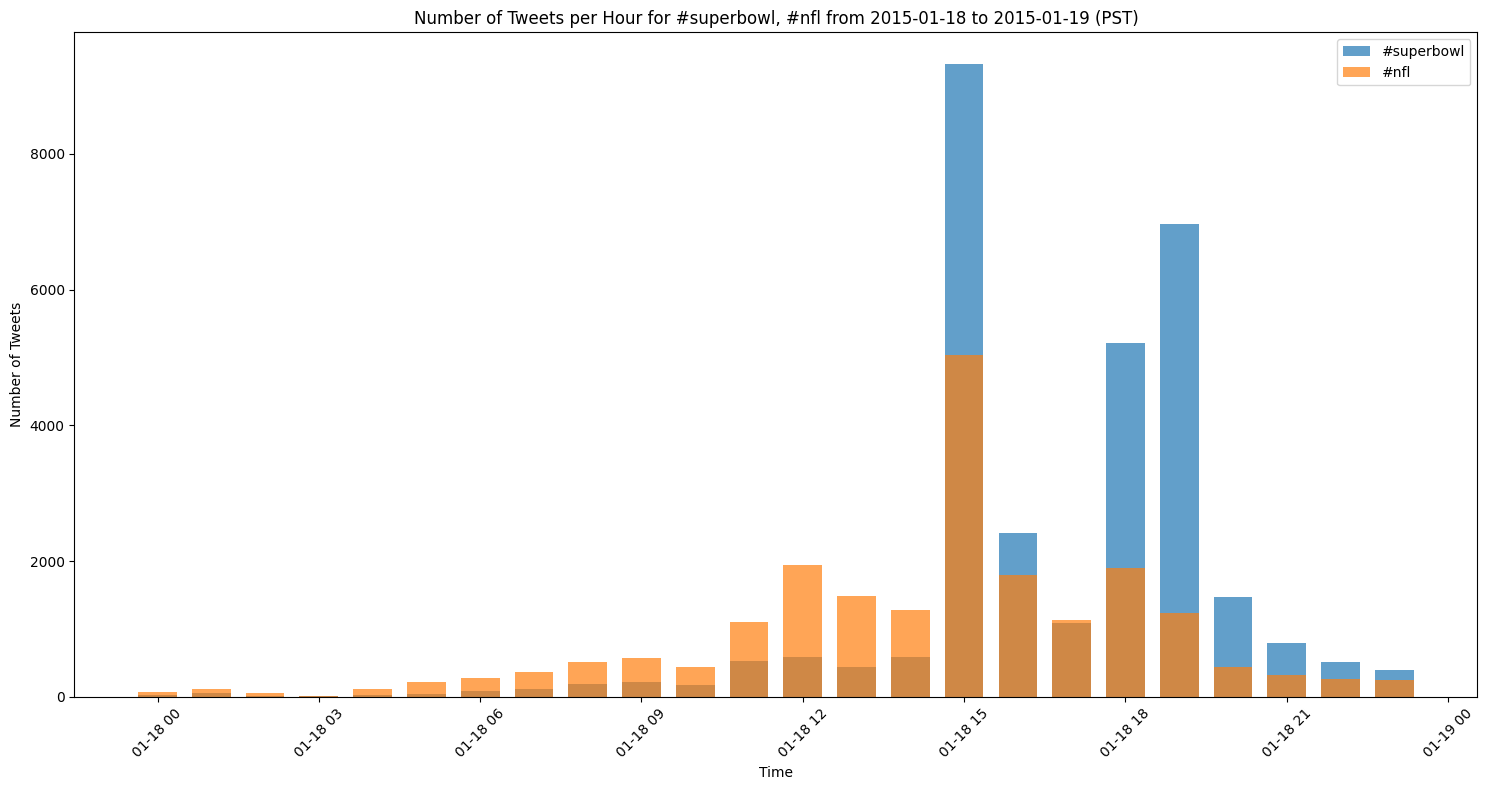

In [23]:
# lets look at the championship games
filter_resample_plot(df, '2015-01-18', '2015-01-19', ['superbowl', 'nfl'])

Clearly the NFL dataset isn't large compared to Superbowl related hashtags.  Also, the NFL category will be broader and the data likely more generalized to other teams and topics.  This dataset will be discarded for further analysis.

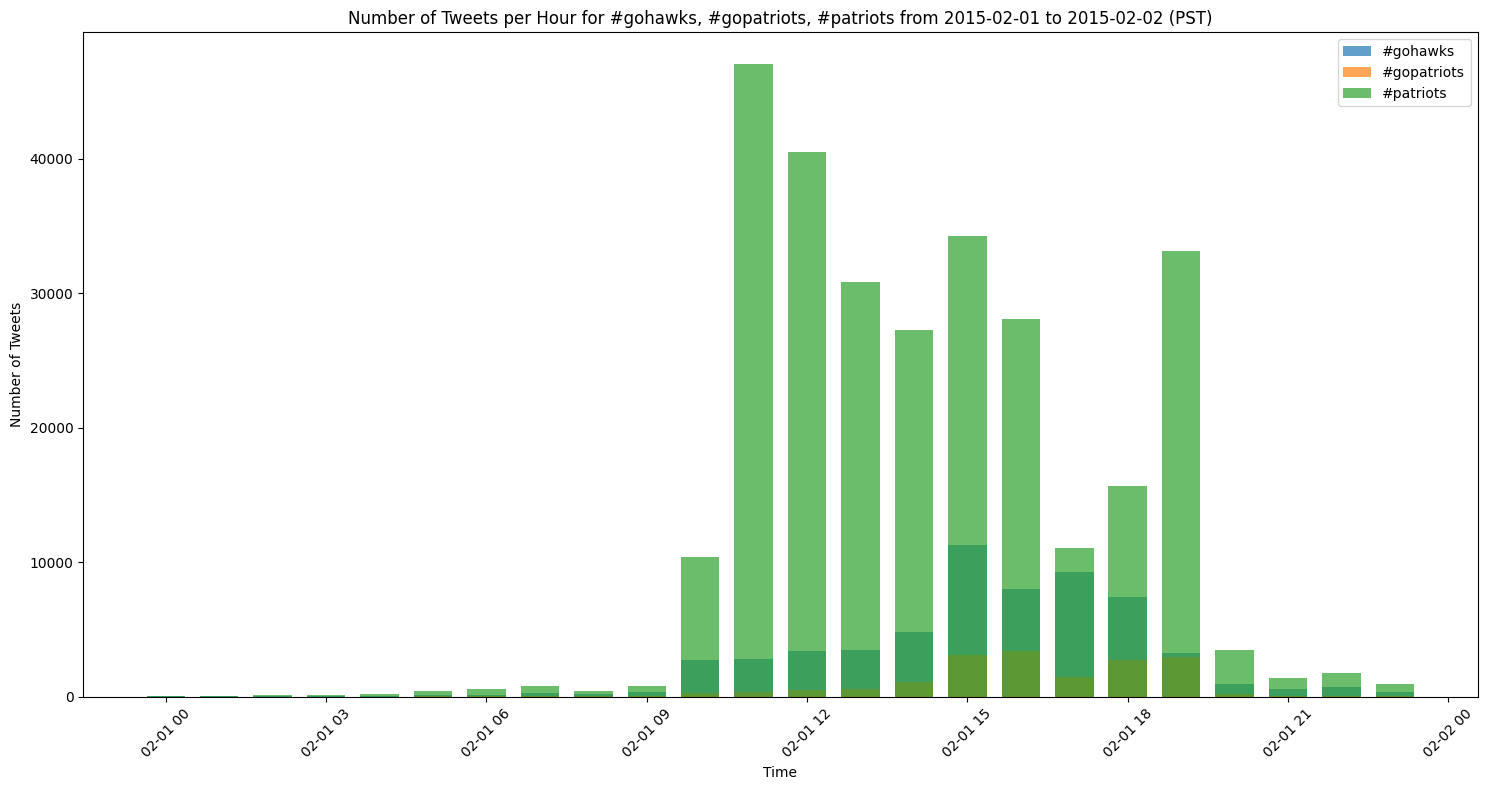

In [24]:
# lets look at other hashtags
filter_resample_plot(df, '2015-02-01', '2015-02-02', ['gohawks', 'gopatriots', 'patriots'])

I can see that I have an imbalance of tweets in favor of the patriots.

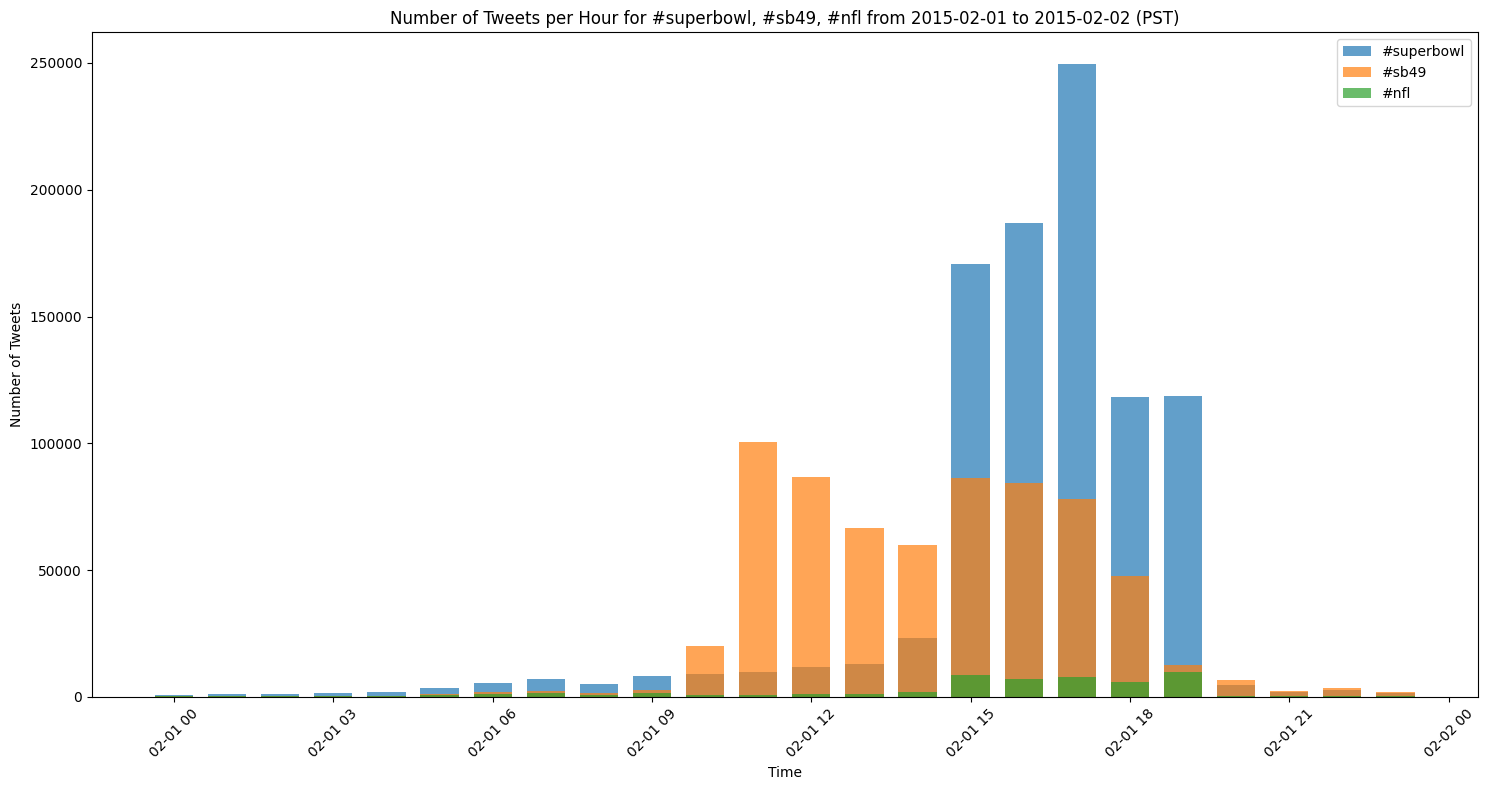

In [25]:
# what about just the superbowl or neutral hashtags
filter_resample_plot(df, '2015-02-01', '2015-02-02', ['superbowl', 'sb49', 'nfl'])

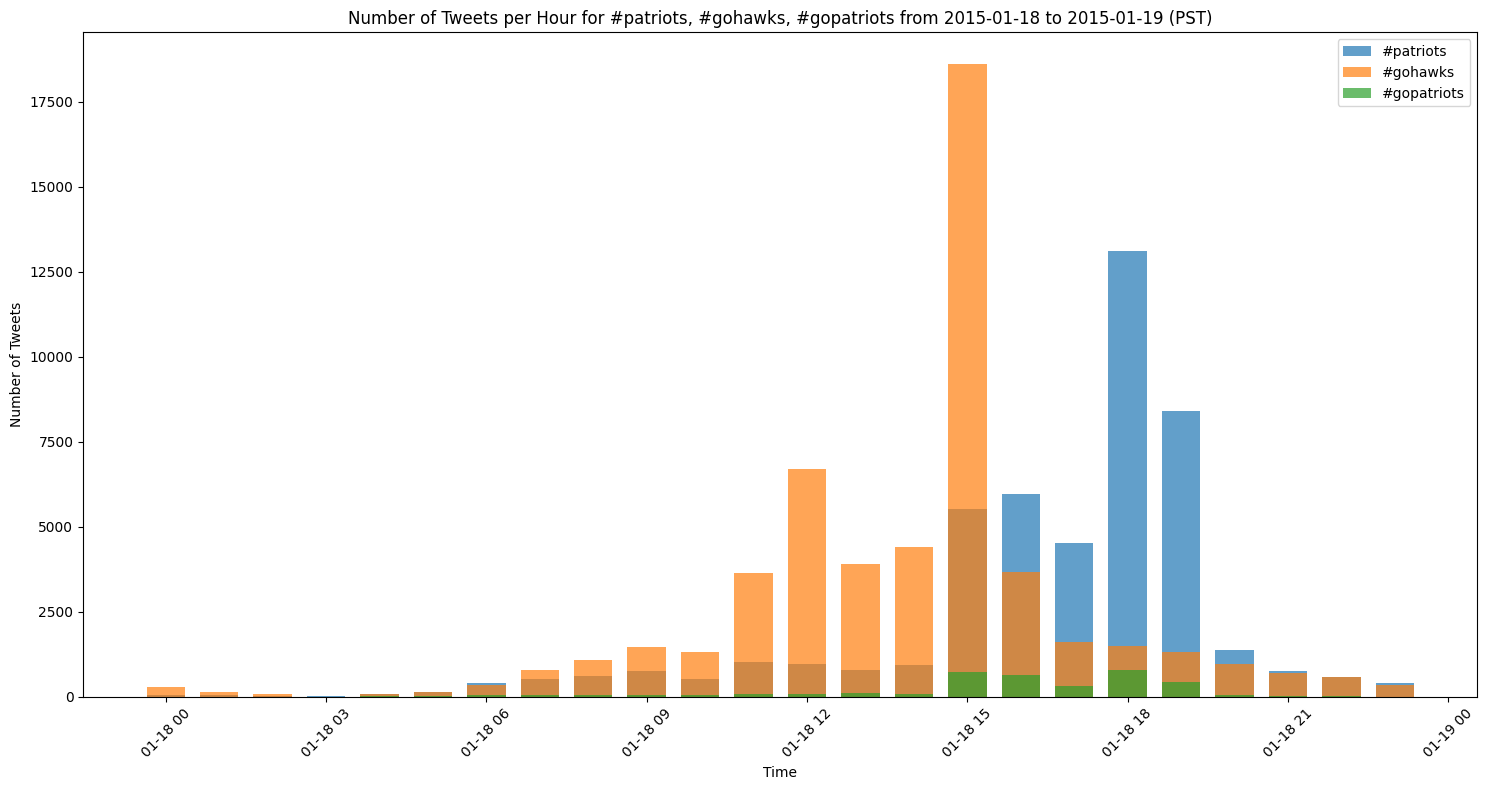

In [26]:
# how about the patriots and seahawks on 1/18/15
filter_resample_plot(df, '2015-01-18', '2015-01-19', ['patriots', 'gohawks', 'gopatriots'])

Well, it seems we would be wise to choose the Superbowl timeframe, I do not see enough consistent nor high volume tweet data in this timeframe.

# Create a feature dataset from the event logs from the game

In [27]:
# function to correlate football game time to real time
def correlate_game_clock_to_real_time(game_start_time, quarter, time_left_in_quarter):
    """
    Correlate football game clock to the actual time of day.

    Parameters:
    game_start_time (datetime): The real-world start time of the game.
    quarter (int): The current quarter (1 to 4).
    time_left_in_quarter (str): Time left in the quarter in "MM:SS" format.

    Returns:
    datetime: The actual time of day corresponding to the game clock.
    """
    # Duration of each quarter in minutes
    quarter_duration = 15
    # Duration of halftime break in minutes (actual was 12:41)
    halftime_duration = 13

    # Convert time left in quarter to timedelta
    minutes, seconds = map(int, time_left_in_quarter.split(':'))
    time_left = timedelta(minutes=minutes, seconds=seconds)

    # Calculate elapsed game time before the current quarter
    elapsed_game_time = timedelta()
    if quarter > 1:
        elapsed_game_time += timedelta(minutes=(quarter - 1) * quarter_duration)
    if quarter > 2:
        elapsed_game_time += timedelta(minutes=halftime_duration)

    # Calculate elapsed real time before the current quarter
    # Adding average additional time for breaks, stoppages, etc.
    avg_additional_time_per_quarter = 51.5  #this value aligned the final touchdown with the actual time of 7:15 pm PST
    elapsed_real_time = elapsed_game_time + timedelta(minutes=(quarter - 1) * avg_additional_time_per_quarter)

    # Calculate the actual time of day
    actual_time = game_start_time + elapsed_real_time + (timedelta(minutes=quarter_duration) - time_left)

    return actual_time

In [28]:
game_log_df = pd.read_csv('/content/drive/My Drive/twitter/game_log.csv')

In [29]:
# drop NaN values
game_log_df = game_log_df.dropna()

# clean up game_time column to remove extra quotes
game_log_df['game_time'] = game_log_df['game_time'].str.replace('"', '')

In [30]:
print(game_log_df)

   team_action        action game_time  quarter  patriots_score  \
0     patriots          punt     11:44      1.0             0.0   
1     seahawks          punt     09:30      1.0             0.0   
2     patriots  interception     01:50      1.0             0.0   
3     seahawks          punt     14:08      2.0             0.0   
4     patriots     touchdown     09:47      2.0             7.0   
5     seahawks          punt     08:17      2.0             7.0   
6     patriots          punt     07:17      2.0             7.0   
7     seahawks     touchdown     02:16      2.0             7.0   
8     patriots     touchdown     00:31      2.0            14.0   
9     seahawks     touchdown     00:02      2.0            14.0   
10    seahawks    field_goal     11:09      3.0            14.0   
11    patriots  interception     08:15      3.0            14.0   
12    seahawks     touchdown     04:54      3.0            14.0   
13    patriots          punt     03:24      3.0            14.

# Find the real time approximation for the superbowl game events

In [31]:
# define the game start time
game_start_time = datetime(2015, 2, 1, 15, 30)  # actual game start time at 3:30 PM PST

# function to add the real time to the game_log dataframe
def add_real_time(row):
    return correlate_game_clock_to_real_time(game_start_time, row['quarter'], row['game_time'])

# apply add real time function to each row in the game_log dataframe
game_log_df['real_time'] = game_log_df.apply(add_real_time, axis=1)

#print the game_log dataframe
print(game_log_df)

   team_action        action game_time  quarter  patriots_score  \
0     patriots          punt     11:44      1.0             0.0   
1     seahawks          punt     09:30      1.0             0.0   
2     patriots  interception     01:50      1.0             0.0   
3     seahawks          punt     14:08      2.0             0.0   
4     patriots     touchdown     09:47      2.0             7.0   
5     seahawks          punt     08:17      2.0             7.0   
6     patriots          punt     07:17      2.0             7.0   
7     seahawks     touchdown     02:16      2.0             7.0   
8     patriots     touchdown     00:31      2.0            14.0   
9     seahawks     touchdown     00:02      2.0            14.0   
10    seahawks    field_goal     11:09      3.0            14.0   
11    patriots  interception     08:15      3.0            14.0   
12    seahawks     touchdown     04:54      3.0            14.0   
13    patriots          punt     03:24      3.0            14.

# Parse and process tweet text

In [32]:
# function to filter by datetime and hashtag
def filter_by_datetime_and_hashtag(df, start_datetime_str, end_datetime_str, hashtags):
    """
    Filter tweet data by date, time, and hashtag.

    Parameters:
    start_datetime_str (str): The start datetime in 'YYYY-MM-DD HH:MM' format.
    end_datetime_str (str): The end datetime in 'YYYY-MM-DD HH:MM' format.
    hashtags (list): List of hashtags to filter.

    Returns:
    pd.DataFrame: Filtered DataFrame.
    """
    # Convert start and end datetimes to datetime with timezone, including minutes
    seattle_tz = pytz.timezone('US/Pacific')
    start_datetime = seattle_tz.localize(datetime.strptime(start_datetime_str, '%Y-%m-%d %H:%M'))
    end_datetime = seattle_tz.localize(datetime.strptime(end_datetime_str, '%Y-%m-%d %H:%M'))

    # Filter data for the specific datetime range in PST timezone
    filtered_df = df[(df['time_posted'] >= start_datetime) & (df['time_posted'] < end_datetime)]

    # Filter data by hashtags
    filtered_df = filtered_df[filtered_df['hashtag'].isin(hashtags)]

    return filtered_df

In [33]:
# we'll parse this data down to tweets on superbowl sunday from 3 pm to 8 pm
# and only use the known fans in the dataset
df_filtered = filter_by_datetime_and_hashtag(df, '2015-02-01 15:00', '2015-02-01 20:00', ['gohawks', 'gopatriots', 'patriots'])

In [34]:
# check content and size of dataset
print(df_filtered.head())
print(df_filtered.shape)

                     time_posted  retweets  followers     author_name  \
14074  2015-02-01 16:01:21-08:00         3       27.0    Karinna Bunn   
94124  2015-02-01 16:23:20-08:00         8      191.0        12121212   
102917 2015-02-01 16:56:44-08:00         6      340.0    The Orca Inn   
103247 2015-02-01 17:09:02-08:00       155      141.0  Keirstin Ariel   
103458 2015-02-01 16:52:03-08:00        21    15086.0      Alexsandra   

        hashtag                                               text  
14074   gohawks                    #GoHawks http://t.co/5tIhnn3TMG  
94124   gohawks  Just for Super Bowl Week and #Tittytuesday  #g...  
102917  gohawks  “@NW_Music_Scene: #GoHawks and Go @NikkiSixx ....  
103247  gohawks  RT to win! 1 winner will receive a signed @Mon...  
103458  gohawks  .@BostonBallet #SB49 challenge: @Seahawks win=...  
(175137, 6)


In [36]:
# function to clean the tweet text data
def clean_tweet_text(tweet_text):
    """
    Clean tweet text by removing URLs, mentions, hashtags (keeping only the text),
    words with numbers, special characters, and extra whitespace, and converting text to lowercase.

    Parameters:
    tweet_text (str): The original tweet text.

    Returns:
    str: The cleaned tweet text.
    """
    # Remove URLs
    tweet_text = re.sub(r'http\S+|www\S+|https\S+', '', tweet_text, flags=re.MULTILINE)

    # Remove mentions
    tweet_text = re.sub(r'@\w+', '', tweet_text)

    # Remove hashtags but keep the text
    tweet_text = re.sub(r'#(\w+)', r'\1', tweet_text)

    # Remove words containing numbers
    tweet_text = re.sub(r'\b\w*\d\w*\b', '', tweet_text)

    # Remove special characters, numbers, and punctuations (except apostrophes)
    tweet_text = re.sub(r'[^A-Za-z\s\']', '', tweet_text)

    # Convert to lowercase
    tweet_text = tweet_text.lower()

    # Remove extra whitespace
    tweet_text = tweet_text.strip()
    tweet_text = re.sub(r'\s+', ' ', tweet_text)

    # Tokenize the tweet text
    words = word_tokenize(tweet_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_text = ' '.join(word for word in words if word not in stop_words)

    return cleaned_text

In [37]:
# use the clean_tweet_text function to clean the text in the dataframe
df_filtered['cleaned_text'] = df_filtered['text'].apply(clean_tweet_text)

In [38]:
print(df_filtered.head())

                     time_posted  retweets  followers     author_name  \
14074  2015-02-01 16:01:21-08:00         3       27.0    Karinna Bunn   
94124  2015-02-01 16:23:20-08:00         8      191.0        12121212   
102917 2015-02-01 16:56:44-08:00         6      340.0    The Orca Inn   
103247 2015-02-01 17:09:02-08:00       155      141.0  Keirstin Ariel   
103458 2015-02-01 16:52:03-08:00        21    15086.0      Alexsandra   

        hashtag                                               text  \
14074   gohawks                    #GoHawks http://t.co/5tIhnn3TMG   
94124   gohawks  Just for Super Bowl Week and #Tittytuesday  #g...   
102917  gohawks  “@NW_Music_Scene: #GoHawks and Go @NikkiSixx ....   
103247  gohawks  RT to win! 1 winner will receive a signed @Mon...   
103458  gohawks  .@BostonBallet #SB49 challenge: @Seahawks win=...   

                                             cleaned_text  
14074                                             gohawks  
94124               

In [39]:
# lemmatize the text

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """
    Convert Treebank part-of-speech tags to WordNet part-of-speech tags.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    """
    Lemmatize the input text.

    Parameters:
    text (str): The input text to lemmatize.

    Returns:
    str: The lemmatized text.
    """
    # Tokenize the text
    words = word_tokenize(text)
    # Get part-of-speech tags for the words
    pos_tags = pos_tag(words)
    # Lemmatize each word with its part-of-speech tag
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    # Join the lemmatized words back into a single string
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

In [40]:
# lemmatize the text and add it as a column in the dataframe
df_filtered['lemmatized_text'] = df_filtered['cleaned_text'].apply(lemmatize_text)

In [41]:
print(df_filtered.head())

                     time_posted  retweets  followers     author_name  \
14074  2015-02-01 16:01:21-08:00         3       27.0    Karinna Bunn   
94124  2015-02-01 16:23:20-08:00         8      191.0        12121212   
102917 2015-02-01 16:56:44-08:00         6      340.0    The Orca Inn   
103247 2015-02-01 17:09:02-08:00       155      141.0  Keirstin Ariel   
103458 2015-02-01 16:52:03-08:00        21    15086.0      Alexsandra   

        hashtag                                               text  \
14074   gohawks                    #GoHawks http://t.co/5tIhnn3TMG   
94124   gohawks  Just for Super Bowl Week and #Tittytuesday  #g...   
102917  gohawks  “@NW_Music_Scene: #GoHawks and Go @NikkiSixx ....   
103247  gohawks  RT to win! 1 winner will receive a signed @Mon...   
103458  gohawks  .@BostonBallet #SB49 challenge: @Seahawks win=...   

                                             cleaned_text  \
14074                                             gohawks   
94124             

# Add sentiment analysis features to the dataset

In [42]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Check if CUDA (GPU) is available and move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [43]:
def predict_sentiment(text):
    """
    Predict the sentiment score of a tweet.

    Parameters:
    text (str): The input tweet text.

    Returns:
    dict: The sentiment scores for positive, neutral, and negative.
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    # Move logits to CPU for processing
    scores = outputs.logits.cpu().numpy()[0]
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(torch.tensor(scores), dim=0).numpy()

    return {
        "negative": probabilities[0],
        "neutral": probabilities[1],
        "positive": probabilities[2]
    }

In [44]:
# Add sentiment scores to the dataframe as features
df_filtered['sentiment_scores'] = df_filtered['lemmatized_text'].apply(predict_sentiment)

In [45]:
# Split sentiment scores into separate columns
df_filtered['sentiment_negative'] = df_filtered['sentiment_scores'].apply(lambda x: x['negative'])
df_filtered['sentiment_neutral'] = df_filtered['sentiment_scores'].apply(lambda x: x['neutral'])
df_filtered['sentiment_positive'] = df_filtered['sentiment_scores'].apply(lambda x: x['positive'])

In [46]:
print(df_filtered.head())

                     time_posted  retweets  followers     author_name  \
14074  2015-02-01 16:01:21-08:00         3       27.0    Karinna Bunn   
94124  2015-02-01 16:23:20-08:00         8      191.0        12121212   
102917 2015-02-01 16:56:44-08:00         6      340.0    The Orca Inn   
103247 2015-02-01 17:09:02-08:00       155      141.0  Keirstin Ariel   
103458 2015-02-01 16:52:03-08:00        21    15086.0      Alexsandra   

        hashtag                                               text  \
14074   gohawks                    #GoHawks http://t.co/5tIhnn3TMG   
94124   gohawks  Just for Super Bowl Week and #Tittytuesday  #g...   
102917  gohawks  “@NW_Music_Scene: #GoHawks and Go @NikkiSixx ....   
103247  gohawks  RT to win! 1 winner will receive a signed @Mon...   
103458  gohawks  .@BostonBallet #SB49 challenge: @Seahawks win=...   

                                             cleaned_text  \
14074                                             gohawks   
94124             

In [47]:
# create a pickle file of the sentiment feature additon to the dataset
df_filtered.to_pickle('/content/drive/My Drive/twitter/twitter_sentiment.pkl')

In [50]:
# convert game_log_df to UTC time prior to saving to a pickle file
game_log_df['real_time'] = game_log_df['real_time'].dt.tz_localize(None)

# create pickle file for game_log_df

game_log_df.to_pickle('/content/drive/My Drive/twitter/game_log_df.pkl')